### Import opencl modules

In [1]:
from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params
from microsim.opencl.ramp.simulator import Simulator
import os

### Setup params for all runs

In [2]:
params = Params(
        retail_multiplier=1.0,
        primary_school_multiplier=1.0,
        secondary_school_multiplier=1.0,
        home_multiplier=1.0,
        work_multiplier=1.0,
        current_risk_beta=0.0165
    )

### Run OpenCL simulation for multiple repetitions

In [3]:
opencl_dir = "./opencl"
snapshot_filepath = os.path.join(opencl_dir, "snapshots", "cache.npz")

iterations = 100
repetitions = 5
summaries = []
num_seed_days = 5
use_gpu=False

for i in range(repetitions):
    # load snapshot
    snapshot = Snapshot.load_full_snapshot(path=snapshot_filepath)
    
    # set params
    snapshot.params = params
    
    # set the random seed of the model for each repetition, otherwise it is completely deterministic
    snapshot.seed_prngs(i)

    # seed initial infections using GAM initial cases
    data_dir = os.path.join(opencl_dir, "data")
    snapshot.seed_initial_infections(num_seed_days=num_seed_days, data_dir=data_dir)

    # Create a simulator and upload the snapshot data to the OpenCL device
    kernel_dir = os.path.join(opencl_dir, "ramp", "kernels")
    simulator = Simulator(snapshot, kernel_dir=kernel_dir, gpu=use_gpu)
    simulator.upload_all(snapshot.buffers)
    
    print(f"Running simulation {i+1} out of {repetitions}")
    summary, final_state = run_headless(simulator, snapshot, iterations, quiet=True)
    summaries.append(summary)
    print("Final counts:")
    summary.print_counts(iterations-1)

/home/rory/miniconda3/envs/ramp-ua/lib/python3.7/site-packages/pyopencl/__init__.py:254: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


Running simulation 1 out of 5


Running simulation: 100%|██████████| 100/100 [00:08<00:00, 11.27it/s]


Final counts:
	Susceptible: 329004
	Exposed: 197
	Presymptomatic: 189
	Asymptomatic: 1116
	Symptomatic: 1200
	Recovered: 362313
	Dead: 1290
Running simulation 2 out of 5


Running simulation: 100%|██████████| 100/100 [00:08<00:00, 12.18it/s]


Final counts:
	Susceptible: 331809
	Exposed: 195
	Presymptomatic: 180
	Asymptomatic: 1191
	Symptomatic: 1183
	Recovered: 359436
	Dead: 1315
Running simulation 3 out of 5


Running simulation: 100%|██████████| 100/100 [00:07<00:00, 12.61it/s]


Final counts:
	Susceptible: 328924
	Exposed: 192
	Presymptomatic: 191
	Asymptomatic: 1303
	Symptomatic: 1239
	Recovered: 362127
	Dead: 1333
Running simulation 4 out of 5


Running simulation: 100%|██████████| 100/100 [00:08<00:00, 12.28it/s]


Final counts:
	Susceptible: 329025
	Exposed: 180
	Presymptomatic: 174
	Asymptomatic: 1190
	Symptomatic: 1150
	Recovered: 362254
	Dead: 1336
Running simulation 5 out of 5


Running simulation: 100%|██████████| 100/100 [00:08<00:00, 11.57it/s]

Final counts:
	Susceptible: 328950
	Exposed: 169
	Presymptomatic: 151
	Asymptomatic: 1013
	Symptomatic: 991
	Recovered: 362721
	Dead: 1314


### Plot output summary data

In [4]:
import matplotlib.pyplot as plt
from microsim.opencl.ramp.disease_statuses import DiseaseStatus


def plot_summary_counts(summary, repetition_num):
    x = range(iterations)
    
    for disease_status in DiseaseStatus:
        plt.plot(x, summary.total_counts[disease_status.value], label=disease_status.name)
    
    plt.title(f"Results - repetition {repetition_num}")
    plt.legend() 
    plt.show()
    

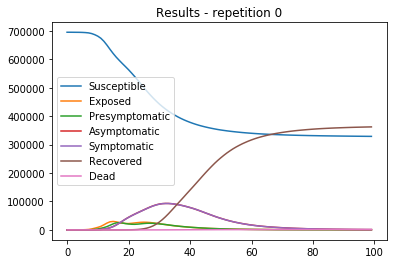

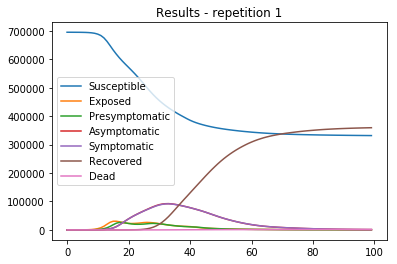

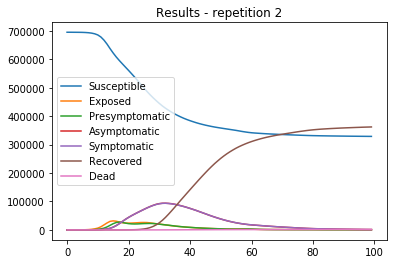

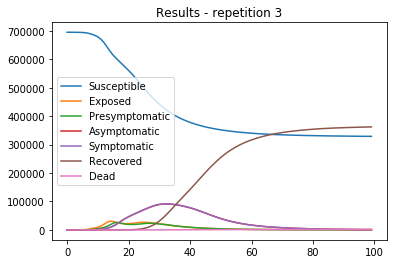

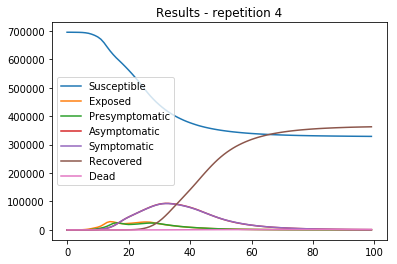

In [5]:
for i, summary in enumerate(summaries):
    plot_summary_c(summary, i)


### Plot disease statuses by age

In [ ]:

def plot_disease_status_by_age(summary, disease_status):
    age_bins = summary.age_bins
    age_counts = summary.age_counts
    
    for (i, age_bin) in enumerate(age_bins):
        
    

In [6]:
age_data = summaries[0].age_counts
print(age_data)

{'susceptible': array([[142453., 142453., 142446., 142429., 142416., 142308., 142137.,
        141752., 140707., 139095., 137765., 137100., 136851., 136605.,
        136291., 135765., 135037., 134154., 132875., 131364., 129564.,
        127392., 124813., 122070., 119023., 115816., 112448., 109044.,
        105537., 102175.,  99018.,  96298.,  93731.,  91364.,  89253.,
         87381.,  85500.,  83830.,  82254.,  80826.,  79447.,  78178.,
         77065.,  76003.,  75056.,  74163.,  73305.,  72506.,  71774.,
         71101.,  70466.,  69925.,  69383.,  68860.,  68422.,  67987.,
         67584.,  67192.,  66863.,  66542.,  66258.,  65973.,  65730.,
         65494.,  65282.,  65054.,  64884.,  64686.,  64543.,  64392.,
         64237.,  64083.,  63927.,  63811.,  63693.,  63589.,  63491.,
         63394.,  63303.,  63229.,  63145.,  63091.,  63012.,  62942.,
         62878.,  62818.,  62765.,  62726.,  62663.,  62613.,  62545.,
         62492.,  62444.,  62401.,  62352.,  62303.,  62253.,